##Read in data for the first time

In [11]:
AllData=pd.read_csv('K:\Rainshelter\Wheat 2015-16\LoggedData\RainShelterAlpha_CS650.dat', #specify file path for data to read in
                         parse_dates=True, #tell the function to parse date columns to datetime formats
                         dayfirst=True, #tell the function that the day is before the year in the data i.e format='%d/%m/%Y %H:%M'
                         skiprows = [0,2,3], #leave out rows 1, 3 and 4 which have redundant information
                         index_col = 0, #Use the first column, which is Date, as an index
                         na_values = 'NAN')

##Apply indexing for the first time

In [12]:
#Bring in index data
AllDataIndex=pd.read_csv('D:\GitHubRepos\RainShelterWheat\IndexFiles\SoilWaterAndTempIndex.csv',
                         index_col = 0)
#Apply indexes to data
AllDataTransposed = AllData.transpose()
AllDataIndexed = pd.concat([AllDataIndex,AllDataTransposed], axis=1)
AllDataIndexed.index.name='ColumnHeader'
AllDataIndexed.set_index(['Measurement','Depth','Nitrogen','Irrigation','Plot','Sensor', 'MUX', 'Port','Units','Summary','Block','Treatment'], 
                        append=False, inplace=True)
AllDataIndexed.sort(inplace=True)
FieldData=AllDataIndexed.transpose()
FieldData.index = FieldData.index.to_datetime()  ## for some reason the concat function changes the data type on the date indes so need to change it back

#Record the last row number read in
LastRow = FieldData.index.size
np.save('LastRow.npy',LastRow)
FieldData.to_pickle('.\FieldData.pkl')

C:\Users\cflhxb\AppData\Roaming\Python\Python27\site-packages\ipykernel\__main__.py:10: FutureWarning:

sort(....) is deprecated, use sort_index(.....)



##Bring in libraries and dataframes and set indexes

In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.tools as tls
from plotly.graph_objs import *
%matplotlib inline

In [2]:
tls.set_credentials_file(username='HamishBrown',
                         api_key='wdly9f0kob', 
                         stream_ids=['vb2iyh03io','b3ups5mc5b','l7xzuy9x4w','3tehbozomt','u7zloau0q6','rpbftetm6d','4e70vk8kvi'],
                         proxy_username='cflhxb', 
                         proxy_password='wakanui/9')
Tokens = tls.get_credentials_file()['stream_ids']

##Read in fresh data and update Graphs

In [3]:
#Bring in date recorded since last update
def UpdataDataFrame():
    #Bring in previous status files
    LastRead = np.load('.\LastRow.npy')
    FieldData = pd.read_pickle('.\FieldData.pkl')
    #Bring in index data
    AllDataIndex=pd.read_csv('D:\GitHubRepos\RainShelterWheat\IndexFiles\SoilWaterAndTempIndex.csv',
                         index_col = 0)
    
    #Bring in fresh data
    StartRead = LastRead + 4
    Skips = [0,2,3] + range(4,StartRead)
    FreshData=pd.read_csv('K:\Rainshelter\Wheat 2015-16\LoggedData\RainShelterAlpha_CS650.dat', #specify file path for data to read in
                             parse_dates=True, #tell the function to parse date columns to datetime formats
                             dayfirst=True, #tell the function that the day is before the year in the data i.e format='%d/%m/%Y %H:%M'
                             skiprows = Skips, #rows that have already be read
                             index_col = 0, #Use the first column, which is Date, as an index
                             na_values = 'NAN')

    #Apply indexes to fresh data
    FreshDataTransposed = FreshData.transpose()
    FreshDataIndexed = pd.concat([AllDataIndex,FreshDataTransposed], axis=1)
    FreshDataIndexed.index.name='ColumnHeader'
    FreshDataIndexed.set_index(['Measurement','Depth','Nitrogen','Irrigation','Plot','Sensor', 'MUX', 'Port','Units','Summary','Block','Treatment'], 
                            append=False, inplace=True)
    FreshDataIndexed.sort(inplace=True)
    NewData=FreshDataIndexed.transpose()
    
    #Join fresh data onto existing data
    FieldData = pd.concat([FieldData,NewData])
    FieldData.sort_index(inplace = True)
    
    #Update status files
    LastRow = FieldData.index.size
    np.save('LastRow.npy',LastRow)
    FieldData.to_pickle('.\FieldData.pkl')
    return FieldData

##Updata data frame and traces and stream to Plotly

In [4]:
#Update Data Frame
FieldData = UpdataDataFrame()
#Calculate treatment means omitting data prior to 2014-11-05 08:00:00 to avoid NaN values
DataMeans =  FieldData.ix['2015-10-10':].groupby(level=['Measurement','Depth','Irrigation', 'Nitrogen'],axis=1).mean()
DataMeans =  DataMeans.dropna(axis=1) #For some reason it keeps non valid combinations in so need to extract with this function

#Calculate the water content of the soil profile by multiplying the volumetric water content by each layers
#depth and summing.  The 0-15 layers are divided by 2 to average the two readings
ProfileWater = DataMeans.VolumetricWaterContent.ix[:,'D1I'] * 150/2 + \
               DataMeans.VolumetricWaterContent.ix[:,'D1B'] * 150/2 + \
               DataMeans.VolumetricWaterContent.ix[:,'D2'] * 150 + \
               DataMeans.VolumetricWaterContent.ix[:,'D3'] * 300 + \
               DataMeans.VolumetricWaterContent.ix[:,'D4'] * 300 + \
               DataMeans.VolumetricWaterContent.ix[:,'D5'] * 300 + \
               DataMeans.VolumetricWaterContent.ix[:,'D6'] * 300 + \
               DataMeans.VolumetricWaterContent.ix[:,'D7'] * 300
                
FieldCapacity = ProfileWater.resample('D', how='max')
FieldCapacity = FieldCapacity.ix['2015-10-14'] +10 # I would have though this would return a data frame with a single row but instead it returns a series with a multiindex in columns
SoilWaterDeficit = -(FieldCapacity - ProfileWater)    # This calculation only works because field capacity is a multi index series

X = SoilWaterDeficit.index
for Treatment in Treatments:
    Treatment.Stream.open()
    Treatment.Stream.write({'x':X,'y':SoilWaterDeficit.ix[:,(Treatment.Irrigation,Treatment.Nitrogen)]})
    Treatment.Stream.close()

C:\Users\cflhxb\AppData\Roaming\Python\Python27\site-packages\ipykernel\__main__.py:26: FutureWarning:

sort(....) is deprecated, use sort_index(.....)

C:\Users\cflhxb\AppData\Roaming\Python\Python27\site-packages\ipykernel\__main__.py:11: FutureWarning:

how in .resample() is deprecated
the new syntax is .resample(...).max()



NameError: name 'Treatments' is not defined

## Calculate soil water deficit

C:\Users\cflhxb\AppData\Roaming\Python\Python27\site-packages\ipykernel\__main__.py:9: FutureWarning:

how in .resample() is deprecated
the new syntax is .resample(...).max()



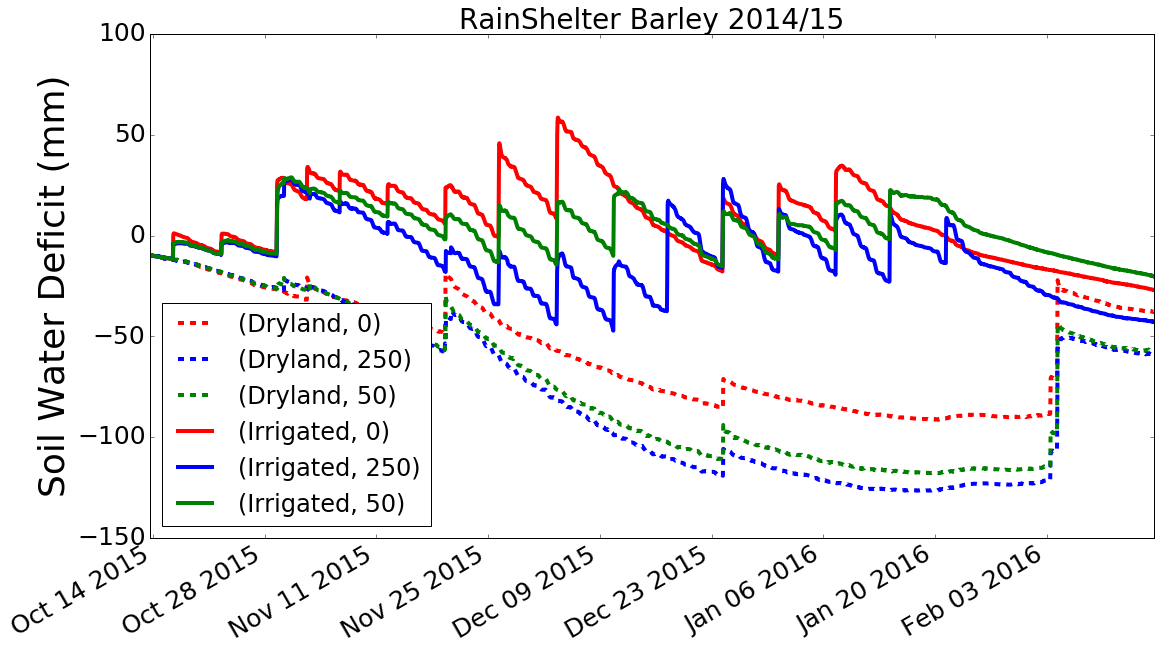

In [5]:
#Calculate treatment means omitting data prior to 2014-11-05 08:00:00 to avoid NaN values
DataMeans =  FieldData.ix['2015-10-10':].groupby(level=['Measurement','Depth','Irrigation', 'Nitrogen'],axis=1).mean()
DataMeans =  DataMeans.dropna(axis=1) #For some reason it keeps non valid combinations in so need to extract with this function

#Calculate the water content of the soil profile by multiplying the volumetric water content by each layers
#depth and summing.  The 0-15 layers are divided by 2 to average the two readings
ProfileWater = DataMeans.VolumetricWaterContent.ix[:,'D1I'] * 150/2 + \
               DataMeans.VolumetricWaterContent.ix[:,'D1B'] * 150/2 + \
               DataMeans.VolumetricWaterContent.ix[:,'D2'] * 150 + \
               DataMeans.VolumetricWaterContent.ix[:,'D3'] * 300 + \
               DataMeans.VolumetricWaterContent.ix[:,'D4'] * 300 + \
               DataMeans.VolumetricWaterContent.ix[:,'D5'] * 300 + \
               DataMeans.VolumetricWaterContent.ix[:,'D6'] * 300 + \
               DataMeans.VolumetricWaterContent.ix[:,'D7'] * 300
                
FieldCapacity = ProfileWater.resample('D', how='max')
FieldCapacity = FieldCapacity.ix['2015-10-14'] +10 # I would have though this would return a data frame with a single row but instead it returns a series with a multiindex in columns
SoilWaterDeficit = -(FieldCapacity - ProfileWater)    # This calculation only works because field capacity is a multi index series
SoilWaterDeficit.plot(figsize=(18,10),style=['r--','b--','g--','r-','b-','g-'], linewidth=4)
plt.ylabel('Soil Water Deficit (mm)', fontsize=36);
plt.tick_params(labelsize=25)
plt.title('RainShelter Barley 2014/15', fontsize=28);
plt.legend(fontsize=24, loc=3)

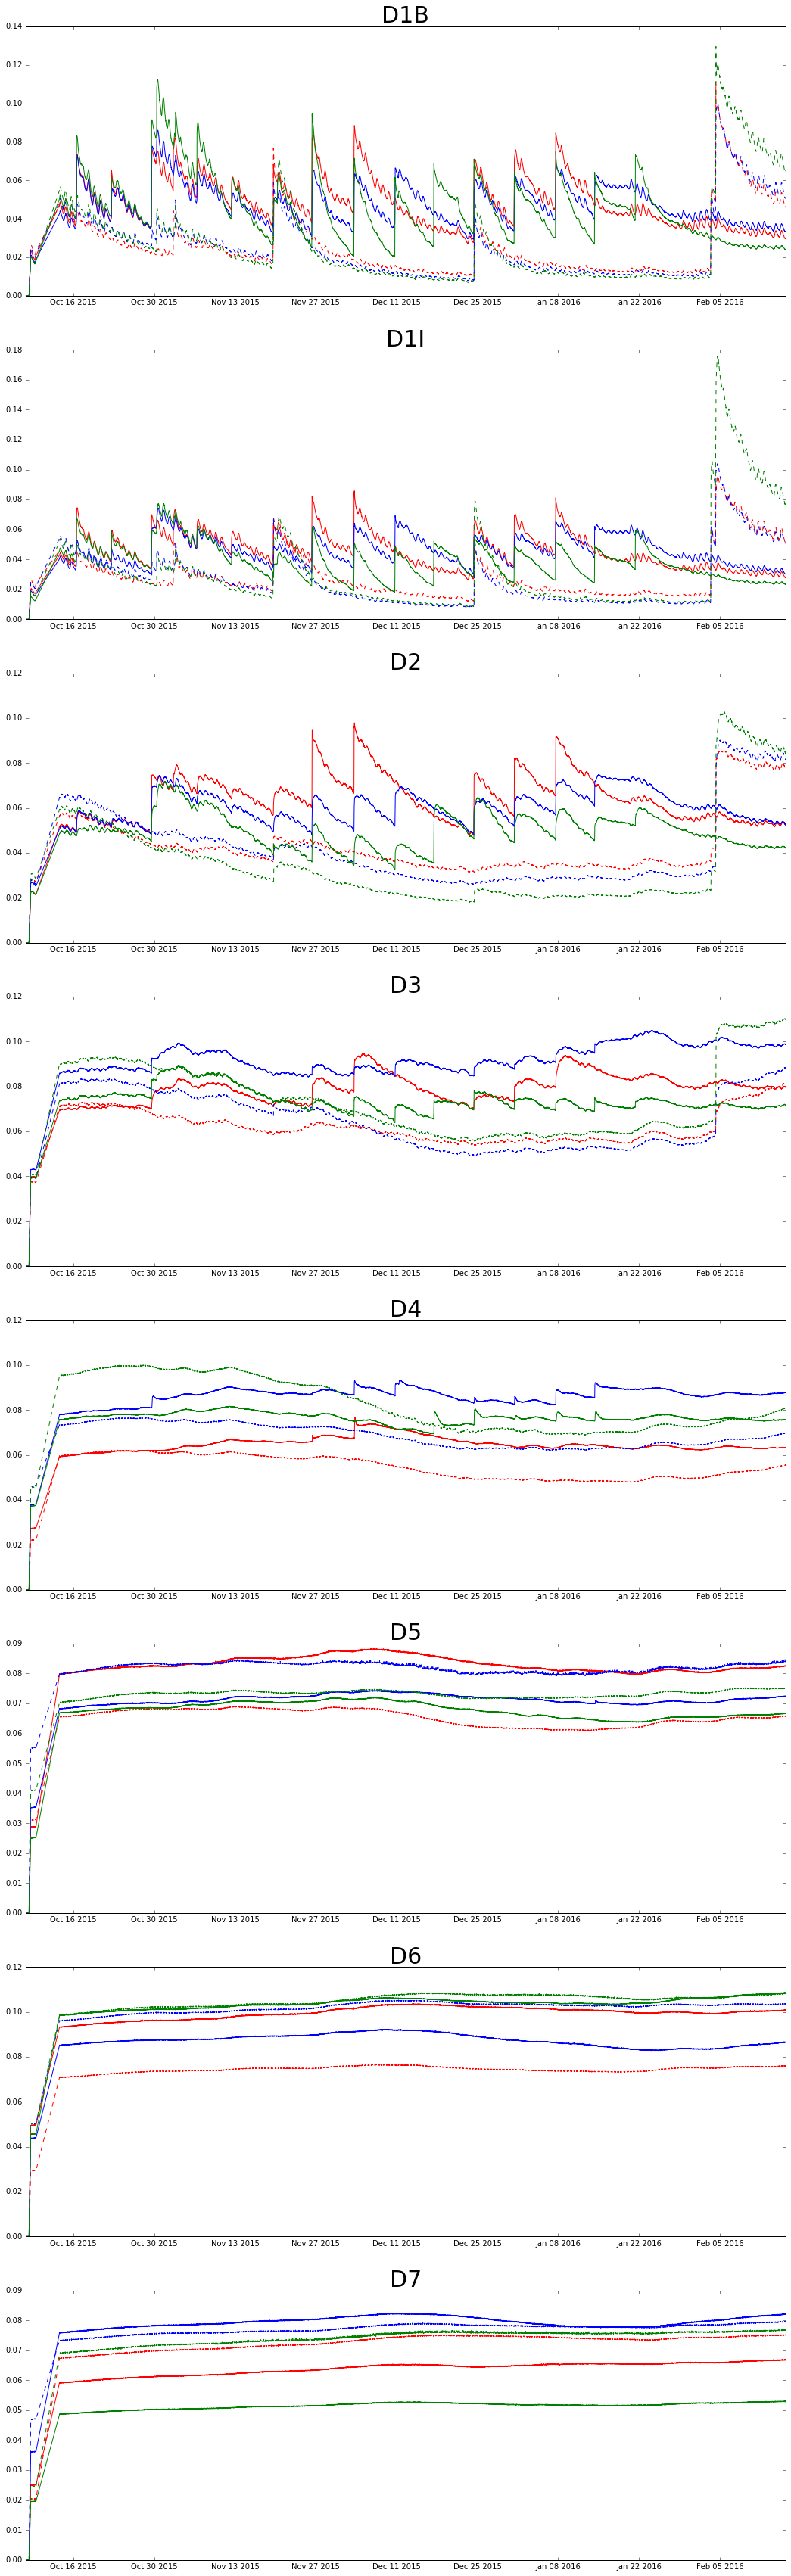

In [6]:
SoilWaterLayers = plt.figure(figsize = (18,60))
Layers = ['D1B', 'D1I', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7']
Colors = ['r','b','g']
NRates = ['0','50','250']
IRates = ['Dryland','Irrigated']
Lines = ['--','-']
Position = 1
for Layer in Layers:
    SoilWaterLayers.add_subplot(8,1,Position)
    ColorPosition = 0
    for NRate in NRates:
        LinePosition = 0
        for IRate in IRates:
            plt.plot(FieldData.ix[:,('ElectricalConductivity',Layer,NRate,IRate)].mean(axis=1).index,
                    FieldData.ix[:,('ElectricalConductivity',Layer,NRate,IRate)].mean(axis=1),
                    color = Colors[ColorPosition], 
                    linestyle = Lines[LinePosition],
                    label = NRate + ' ' + IRate)
            LinePosition +=1
        ColorPosition +=1
    #plt.ylim(0,.45)
    plt.title(Layer, fontsize = 30)
    Position += 1
    if Position == 1:
        plt.legend(.1,.1)

In [28]:
FieldData.to_csv('FieldData.csv')

In [11]:
HourlyMeans = ProfileWater.resample('h').mean()

In [14]:
MidNight = HourlyMeans.ix[HourlyMeans.index.hour==0]

In [17]:
MidNight.to_excel('DailyMeans.xls')